## Configuração do Ambiente e Importação de Bibliotecas

Esta é a célula de setup principal para o notebook. Todas as bibliotecas necessárias para a análise são importadas aqui para garantir a organização e a clareza do código.

Além das importações, esta célula também define:
-   Os caminhos para as pastas do projeto (`data`, `figures`, etc.).
-   Configurações globais para a aparência dos gráficos (`seaborn` e `matplotlib`).
-   Filtros para ignorar avisos de depreciação (`warnings`).

In [13]:
# BIBLIOTECAS PADRÃO 
import re
import os
import warnings
from collections import Counter
from pathlib import Path

# BIBLIOTECAS DE TERCEIROS (INSTALADAS COM PIP)
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm.auto import tqdm

# Bibliotecas específicas que às vezes precisam de importação direta
from networkx.algorithms import community
from nltk.corpus import stopwords
from IPython.display import display

# CONFIGURAÇÕES GLOBAIS

# Ignora avisos de depreciação para um output mais limpo
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Define um tema padrão e mais agradável para todos os gráficos do Seaborn
sns.set_theme(style="whitegrid")

# Define um tamanho padrão para as figuras dos gráficos
plt.rcParams['figure.figsize'] = [14, 7]

# Configura o pandas para usar a barra de progresso do tqdm no .apply()
tqdm.pandas()

# --- 4. DEFINIÇÃO DOS CAMINHOS DO PROJETO ---
# Garante que a raiz do projeto seja detectada corretamente
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()

# Define os caminhos para as outras pastas
DATA_RAW_DIR = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
FIGURES_DIR = PROJECT_ROOT / 'figures'
SCRIPTS_DIR = PROJECT_ROOT / 'scripts'

print(f"✔️ Ambiente configurado. Raiz do projeto: {PROJECT_ROOT}")

✔️ Ambiente configurado. Raiz do projeto: /home/henrique/Documentos/UFV2025/RedesComplexas/ProjetoRedes


In [14]:
# Carrega o dataset de comentários
arquivo_comentarios = DATA_RAW_DIR / 'comentarios.csv'
df = pd.read_csv(arquivo_comentarios)

# Exibe as informações básicas do DataFrame (tipos de dados, valores não nulos)
print("Informações básicas do DataFrame:")
df.info()

# Exibe as 5 primeiras linhas para uma primeira olhada
print("\nAs 5 primeiras linhas do dataset:")
display(df.head())

# Conta o número de participantes únicos
participantes_unicos = df['author'].nunique()
print(f"\nNúmero total de participantes únicos: {participantes_unicos}")

# Exibe os 10 comentários com mais likes
print("\nTop 10 comentários com mais likes:")
display(df.sort_values(by='likes', ascending=False).head(10))

Informações básicas do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282318 entries, 0 to 282317
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   comment_id  282318 non-null  object
 1   author      281849 non-null  object
 2   text        282247 non-null  object
 3   likes       282318 non-null  int64 
 4   timestamp   282318 non-null  object
 5   parent_id   30366 non-null   object
dtypes: int64(1), object(5)
memory usage: 12.9+ MB

As 5 primeiras linhas do dataset:


,comment_id,author,text,likes,timestamp,parent_id
0,Ugx6LlahwTy_MwZiJod4AaABAg,@AnaJúlya-t3d,Ta certo,0,2025-09-29T13:50:17Z,NaN
1,Ugxmtcz6oq7vAgtW5C94AaABAg,@EliasDaniel-y2o,Lei felca,0,2025-09-29T13:21:44Z,NaN
2,UgwZ2v_3Y8folAjlrEl4AaABAg,@EmanuelHeitorSilvaTorres,nojo,0,2025-09-29T11:10:33Z,NaN
3,UgzXc-9-_llf4i-JXu54AaABAg,@EmanuelHeitorSilvaTorres,O8:06 nojo 🤮,0,2025-09-29T11:06:46Z,NaN
4,UgwO8-fTdddUIS4OAjd4AaABAg,@EmanuelHeitorSilvaTorres,que nojo 🤮,0,2025-09-29T11:05:36Z,NaN



Número total de participantes únicos: 238965

Top 10 comentários com mais likes:


,comment_id,author,text,likes,timestamp,parent_id
205671,Ugyzo57XPO4-1W19EQp4AaABAg,@wellingtonlourenco5469,Ele lutou contra as lives de NPC\nEle lutou co...,498149,2025-08-08T21:16:15Z,NaN
180302,UgzsUvdsjJelj7ALqJt4AaABAg,@masgilmar,Perceberam que o FELCA não ativou a monetizaçã...,468339,2025-08-09T01:47:22Z,NaN
280617,UgwIQJJeWqUx9y8pCWV4AaABAg,@leniquexD,"Felca foi lá, cresceu honesto e engraçado. Peg...",373640,2025-08-07T03:10:03Z,NaN
253240,UgyH1UfvNx0xJECDFet4AaABAg,@deborasantos9848,"Isso deveria estar na Netflix, isso não é um v...",256710,2025-08-08T01:26:39Z,NaN
207353,UgwgZNVYt_jck8o291N4AaABAg,@fadereality,"Senhor, protege esse cara, Tem meu respeito!",199351,2025-08-08T21:07:30Z,NaN
278811,UgzAsspH6qcKHMx4Ypp4AaABAg,@Eiicristina,Protejam o felca!!! Esse é o tipo de denuncia...,184018,2025-08-07T04:07:37Z,NaN
279657,UgxL7-LS0cEH3kuCan94AaABAg,@adrianofernandes508,Felca se tornando o Batman da internet ta mto bom,167396,2025-08-07T03:42:20Z,NaN
217157,UgxHddudIKE9l8PzCAl4AaABAg,@cleidianearaujoo,Enfim alguém com um alcance absurdo teve corag...,163748,2025-08-08T19:08:08Z,NaN
121210,Ugwicq9Aar-B7l55_014AaABAg,@laurawaztaken,"eu como tradutora, vou fazer uma legenda em in...",150347,2025-08-09T23:12:36Z,NaN
264515,UgwK3BZYarIPOr0V4sR4AaABAg,@Rodrigo_Goes,"Felca, como pai de meninas o seu vídeo me fez ...",118978,2025-08-07T19:25:35Z,NaN


## Pré-processamento e Limpeza do Texto

Antes de qualquer análise de conteúdo, é fundamental preparar os dados textuais. Esta etapa consiste em uma série de transformações para normalizar o texto, removendo "ruídos" que podem atrapalhar os algoritmos de Processamento de Linguagem Natural (PLN).

O processo de limpeza incluirá:
-   Conversão para letras minúsculas.
-   Remoção de links (URLs).
-   Remoção de pontuação e caracteres especiais.
-   Tokenização (divisão do texto em palavras).
-   Remoção de *stopwords* (palavras comuns em português como 'e', 'de', 'para', que não agregam significado à análise).

O resultado será uma nova coluna em nosso DataFrame, `texto_limpo`, que servirá de base para as análises subsequentes.

In [17]:
# Carrega a lista de stopwords em português para uma variável
stop_words = set(stopwords.words('portuguese'))

# Define a função que fará a limpeza de um texto individual
def limpar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    texto = re.sub(r'[^\w\s]', '', texto)
    lista_palavras = texto.split()
    palavras_sem_stopwords = [palavra for palavra in lista_palavras if palavra not in stop_words]
    return " ".join(palavras_sem_stopwords)

# Aplica a função de limpeza na coluna 'text' usando o .apply() padrão
df['texto_limpo'] = df['text'].astype(str).apply(limpar_texto)

# Exibe o "antes e depois" para os 5 primeiros comentários, para verificação
print("Resultado da limpeza (Antes vs. Depois):")
display(df[['text', 'texto_limpo']].head())

Resultado da limpeza (Antes vs. Depois):


,text,texto_limpo
0,Ta certo,ta certo
1,Lei felca,lei felca
2,nojo,nojo
3,O8:06 nojo 🤮,o806 nojo
4,que nojo 🤮,nojo


## Análise Descritiva dos Comentários

Após o pré-processamento, foi realizada uma análise descritiva para compreender as características e a dinâmica da seção de comentários. Esta etapa foca em quatro eixos principais: a evolução temporal, o engajamento do público, o padrão de participação dos usuários e o conteúdo textual mais frequente.

**Questões de Pesquisa Específicas:**
-   Como o volume de comentários evoluiu ao longo do tempo após a publicação do vídeo?
-   Como o engajamento (medido em "likes") se distribui entre os comentários?
-   A discussão foi dominada por poucos usuários muito ativos ou distribuída entre muitos participantes?
-   Quais foram as palavras mais utilizadas no debate?

**Passos da Análise (Metodologia):**
* **Análise Temporal:** Plotar a quantidade de comentários por dia para visualizar o ciclo de vida da discussão.
* **Análise de Engajamento:** Analisar a distribuição de "likes" para entender a economia da atenção.
* **Análise de Participação:** Investigar a distribuição de comentários por autor para identificar "power users".
* **Análise de Frequência:** Contar as palavras individuais mais comuns e gerar uma nuvem de palavras para um resumo visual do conteúdo.

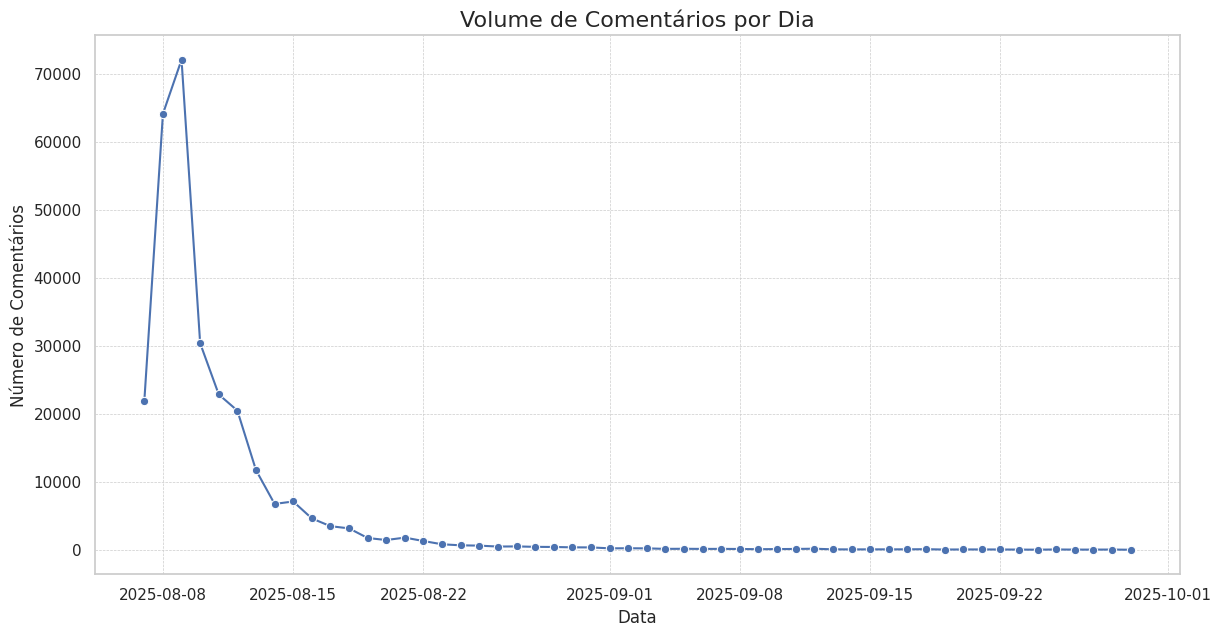

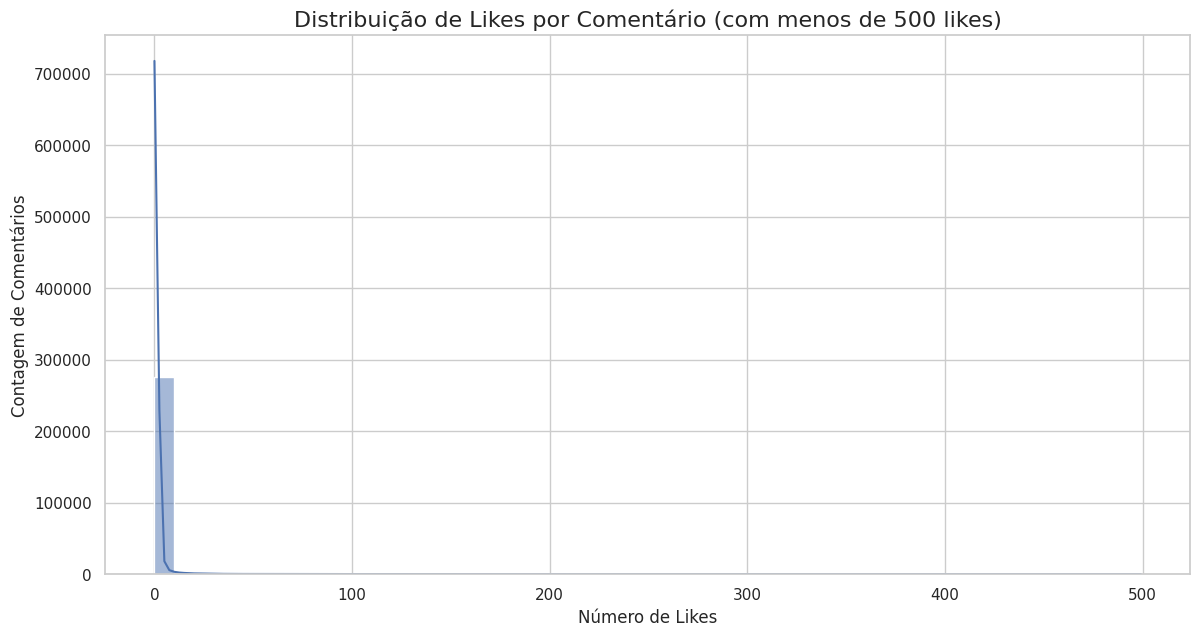

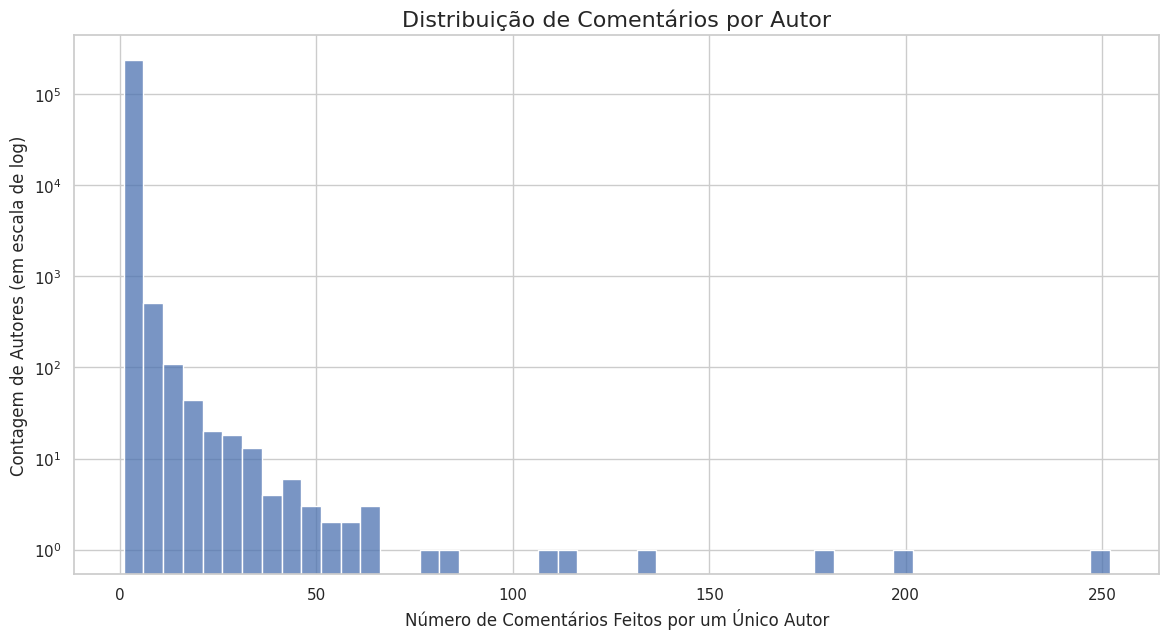

Top 15 autores mais ativos:


author
@katerineoliveira411        252
@Comunista_Enrustida6378    199
@ivi8060                    177
@adrianvantasset8081        132
@DarkDorly                  115
@JoaoPedro-lg9kj            109
@waldeniorocha               84
@totóigameplays              78
@temporariamente24h          66
@Lady-Lambdadelta            64
@danielaviana4778            62
@SantanaWithout4             61
@Loli-iw                     57
@Rosberg-e7u                 54
@Lockdoownn                  52
Name: count, dtype: int64

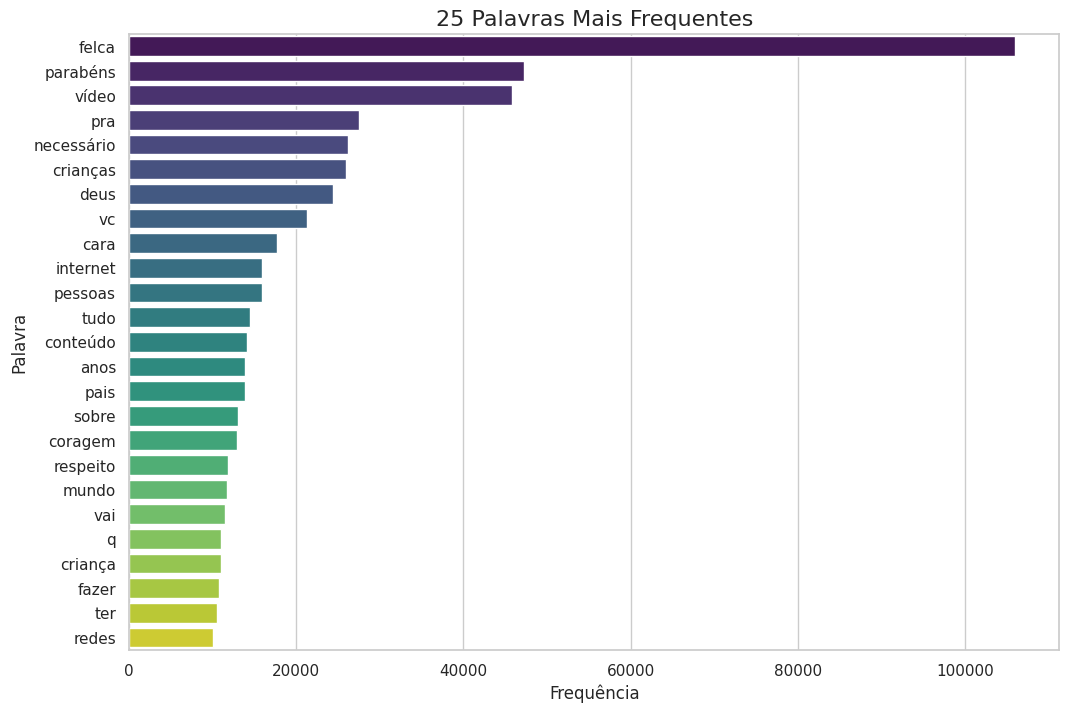

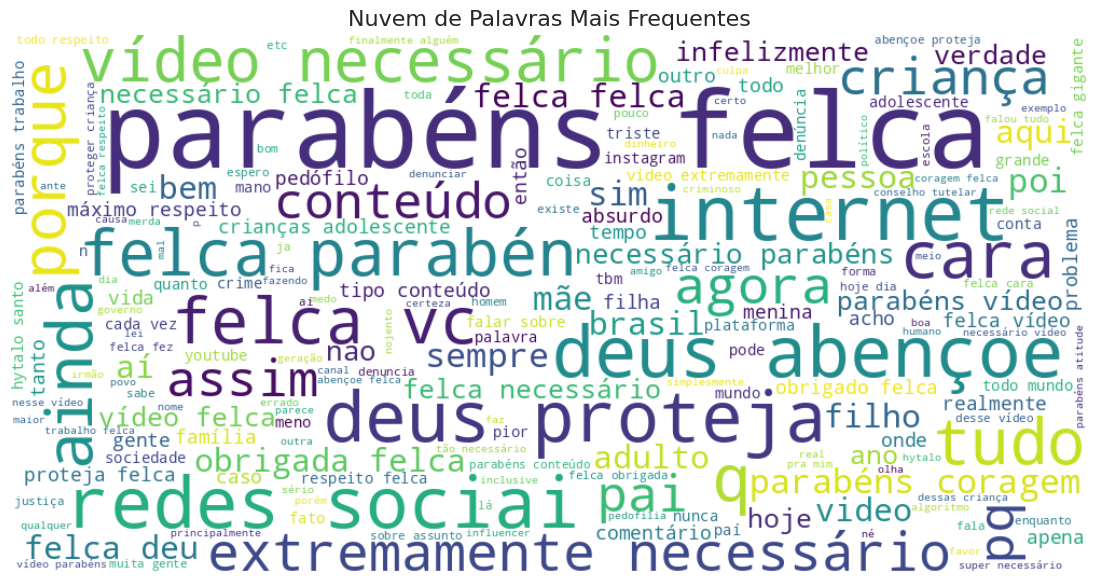

In [16]:
# ANÁLISE TEMPORAL
df['timestamp'] = pd.to_datetime(df['timestamp'])
comentarios_por_dia = df.set_index('timestamp').resample('D').size()

plt.figure(figsize=(14, 7))
sns.lineplot(data=comentarios_por_dia, marker='o')
plt.title('Volume de Comentários por Dia', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Número de Comentários')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# ANÁLISE DE ENGAJAMENTO
plt.figure(figsize=(14, 7))
sns.histplot(df[df['likes'] < 500]['likes'], bins=50, kde=True)
plt.title('Distribuição de Likes por Comentário (com menos de 500 likes)', fontsize=16)
plt.xlabel('Número de Likes')
plt.ylabel('Contagem de Comentários')
plt.show()

# ANÁLISE DE PARTICIPAÇÃO
comentarios_por_autor = df['author'].value_counts()

plt.figure(figsize=(14, 7))
sns.histplot(comentarios_por_autor, bins=50)
plt.yscale('log')
plt.title('Distribuição de Comentários por Autor', fontsize=16)
plt.xlabel('Número de Comentários Feitos por um Único Autor')
plt.ylabel('Contagem de Autores (em escala de log)')
plt.show()

print("Top 15 autores mais ativos:")
display(comentarios_por_autor.head(15))

# ANÁLISE DE FREQUÊNCIA DE PALAVRAs
nltk.download('punkt', quiet=True)
todas_as_palavras = [palavra for texto in df['texto_limpo'].dropna() for palavra in texto.split()]
contagem_palavras = Counter(todas_as_palavras)
df_palavras_comuns = pd.DataFrame(contagem_palavras.most_common(25), columns=['palavra', 'frequencia'])

plt.figure(figsize=(12, 8))
sns.barplot(x='frequencia', y='palavra', data=df_palavras_comuns, palette='viridis')
plt.title('25 Palavras Mais Frequentes', fontsize=16)
plt.xlabel('Frequência')
plt.ylabel('Palavra')
plt.show()

texto_completo = " ".join(todas_as_palavras)
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(texto_completo)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras Mais Frequentes', fontsize=16)
plt.axis('off')
plt.show()